# Progetto preliminare all'esame orale - Data Intensive Application

_Elia Marcantognini matr. 826126_

## Setup

- Importo i package necessari

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os.path
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
%matplotlib inline

## Descrizione del problema
- Si vuole estrarre un modello di conoscenza utile a capire e predire il costo dell'assicurazione medica personale negli Stati Uniti D'America.
- L'obiettivo del progetto è quello di predire una variabile continua, conoscendo le sue features.
- Si fa riferimento a un dataset di pubblico dominio utilizzato come esempio nel libro
    - Machine Learning with R di **Brett Lantz**
- Il dataset è disponibile https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv

## Recupero dei dati

In [2]:
if not os.path.exists("insurance.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv",
                "insurance.csv")

In [3]:
insurance = pd.read_csv("insurance.csv")

## Esplorazione dei dati

In [4]:
insurance.shape

(1338, 7)

In [5]:
insurance.head(3).append(insurance.tail(3))

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [6]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
# controllo la presenza di dati NaN
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Lista delle variabili
- `AGE`: età del contraente;
- `SEX`: genere del contraente;
- `BMI`: indice di massa corporea, utile per capire la fisicità del contraente;
- `CHILDREN`: numero di figli del contraente;
- `SMOKER`: indica se il contraente fuma, variabile binaria [yes, no];
- `REGION`: indica la regione di residenza del contraente.
- **`CHARGES`**: costo dell'assicurazione medica individuale
    - Lo scopo dell'analisi sarà quello di trovare un modello in grado di predire questa variabile in funzione delle altre.

Le features presenti sono di tipo categorico, continuo o discreto.
- Le categoriche sono: `sex`, `smoker` e `region`
- Le continue sono: `age` e `bmi`
- La discreta è: `children`

### Conversione dati categorici

In [8]:
insurance_data = insurance

**Per utilità, creiamo una nuova instanza del dataset in cui convertiamo:**
- La colonna `sex`: 0 per 'female', 1 per 'male'
- La colonna `smoker`: 0 per 'no', 1 per 'yes'
- La colonna `region`: quattro colonne binarie, una per ogni regione

In [9]:
# sex
insurance_data['sex'] = insurance_data['sex'].map({'female':0, 'male':1})
# smoker
insurance_data['smoker'] = insurance_data['smoker'].map({'no':0, 'yes':1})
# region
insurance_data = pd.get_dummies(insurance_data, 'region')
# output
insurance_data.head(5)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


### Variabili categoriche

- Prendiamo in esame la feature `sex`

1    676
0    662
Name: sex, dtype: int64

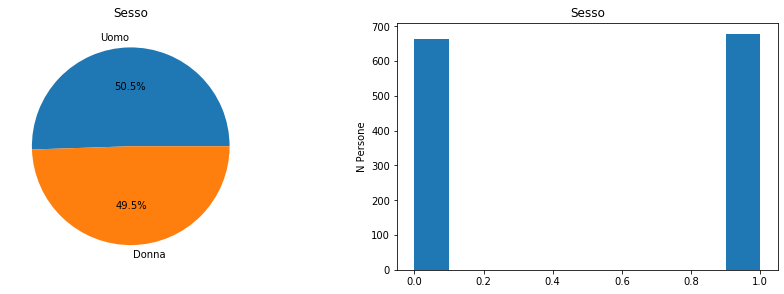

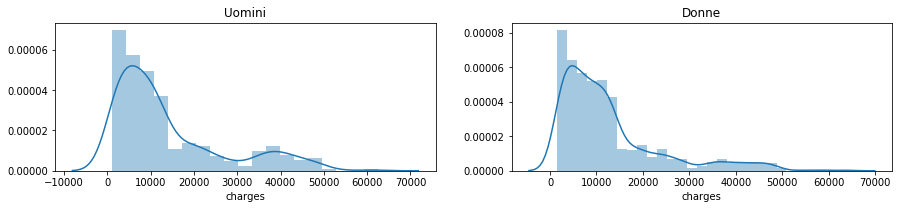

In [10]:
plt.figure(figsize=(15, 10))
# Distribuzione dei sessi
plt.subplot(2, 2, 1)
plt.title('Sesso')
plt.pie(insurance.sex.value_counts(), autopct='%1.1f%%', labels=['Uomo','Donna']);
plt.subplot(2, 2, 2)
plt.title('Sesso')
plt.ylabel('N Persone')
plt.hist(insurance.sex);
# Grafici di distribuzione
man = insurance.loc[insurance_data.sex == 1]
woman = insurance.loc[insurance_data.sex == 0]
plt.figure(figsize=(15,6))
sns.distplot(man['charges'], ax=plt.subplot(2,2,3)).set_title(label='Uomini')
sns.distplot(woman['charges'], ax=plt.subplot(2,2,4)).set_title(label='Donne');
insurance.sex.value_counts()

- Uomini e donne sono praticamente in egual numero all'interno del dataset
- Si può notare che i costi non sono strettamente correlati al sesso, controlliamo calcolando il coefficiente di correlazione di Pearson

In [11]:
# funzione che calcola il coefficiente di correlazione di Pearson
def correlation(a, b):
    return np.mean((a-a.mean()) * (b-b.mean())) / (a.std() * b.std())

In [12]:
correlation(insurance_data.sex, insurance.charges)

0.057249243022502776

- Effettivamente il coefficiente di correlazione è prossimo allo 0, indicando quindi assenza di correlazione

- Prendiamo ora in esame la feature `smoker`

0    1064
1     274
Name: smoker, dtype: int64

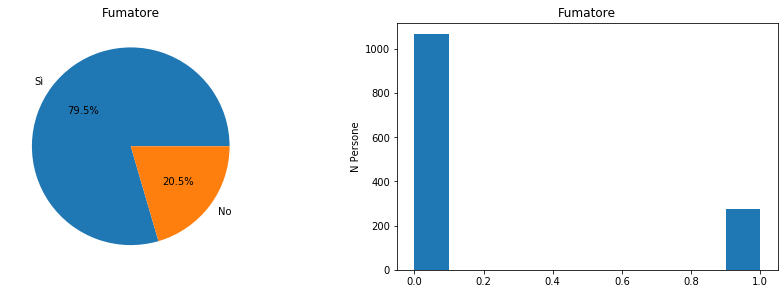

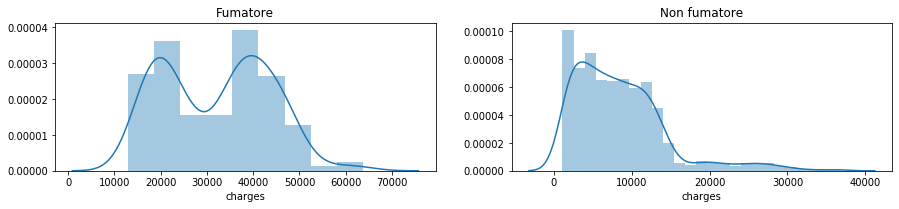

In [13]:
plt.figure(figsize=(15, 10))
# Distribuzione dei fumatori
plt.subplot(2, 2, 1)
plt.title('Fumatore')
plt.pie(insurance.smoker.value_counts(), autopct='%1.1f%%', labels=['Sì','No']);

plt.subplot(2, 2, 2)
plt.title('Fumatore')
plt.ylabel('N Persone')
plt.hist(insurance.smoker)

smoke = insurance_data.loc[insurance_data.smoker == 1]
not_smoke = insurance_data.loc[insurance_data.smoker == 0]
plt.figure(figsize=(15,6))
sns.distplot(smoke['charges'], ax=plt.subplot(2,2,3)).set_title(label='Fumatore')
sns.distplot(not_smoke['charges'], ax=plt.subplot(2,2,4)).set_title(label='Non fumatore');
insurance.smoker.value_counts()


- Nel dataset sono presenti molti più persone fumatrici che non
- Per quanto riguarda la feature `smoker`, sembra esserci una forte correlazione fra l'aumento del costo e un paziente fumatore.

In [14]:
correlation(insurance_data.smoker, insurance_data.charges)

0.7866630512529551

- Effettivamente è risultato un coefficiente prossimo all'1, indicando quindi una correlazione abbastanza forte

- Prendiamo ora in esame la feature `region`

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

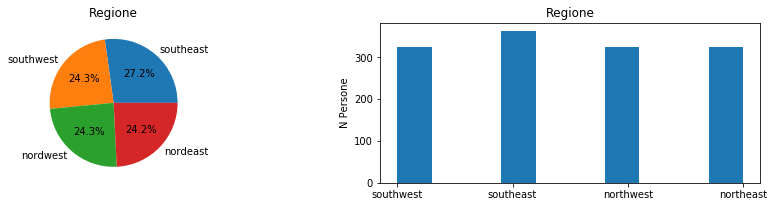

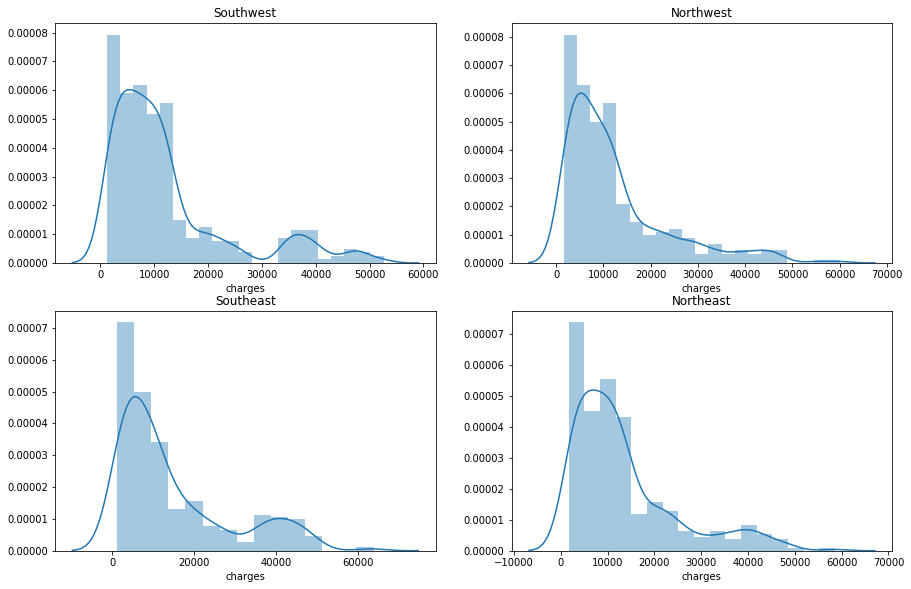

In [15]:
plt.figure(figsize=(15, 10))
# Distribuzione delle regioni
plt.subplot(3, 2, 1)
plt.title('Regione')
plt.pie(insurance.region.value_counts(), autopct='%1.1f%%', labels=[ 'southeast', 'southwest', 'nordwest', 'nordeast']);
plt.subplot(3, 2, 2)
plt.title('Regione')
plt.ylabel('N Persone')
plt.hist(insurance.region)

southwest = insurance.loc[insurance.region == 'southwest']
northwest = insurance.loc[insurance.region == 'northwest']
southeast = insurance.loc[insurance.region == 'southeast']
northeast = insurance.loc[insurance.region == 'northeast']
plt.figure(figsize=(15,15))
sns.distplot(southwest['charges'], ax=plt.subplot(3,2,3)).set_title(label='Southwest')
sns.distplot(northwest['charges'], ax=plt.subplot(3,2,4)).set_title(label='Northwest')
sns.distplot(southeast['charges'], ax=plt.subplot(3,2,5)).set_title(label='Southeast')
sns.distplot(northeast['charges'], ax=plt.subplot(3,2,6)).set_title(label='Northeast');
insurance.region.value_counts()

In [16]:
print("Coefficiente di correlazione:")
print("Southwest {:.5}".format(correlation(insurance_data.region_southwest, insurance_data.charges)))
print("Northwest {:.5}".format(correlation(insurance_data.region_northwest, insurance_data.charges)))
print("Southeast {:.5}".format(correlation(insurance_data.region_southeast, insurance_data.charges)))
print("Northeast {:.5}".format(correlation(insurance_data.region_northeast, insurance_data.charges)))

Coefficiente di correlazione:
Southwest -0.043178
Northwest -0.039875
Southeast 0.073926
Northeast 0.006344


- Come si può intuire dai risultati, le singole regioni non sono strettamente legate all'aumento o alla diminuizione del costo

Dallo studio delle variabili categoriche possiamo capire come solamente la feature `smoker` abbia un impatto importante nella determinazione della variabile `charges`.
Passiamo ora alle variabili continue.

### Variabili continue

##### Analisi della colonna `age`

18    69
19    68
Name: age, dtype: int64

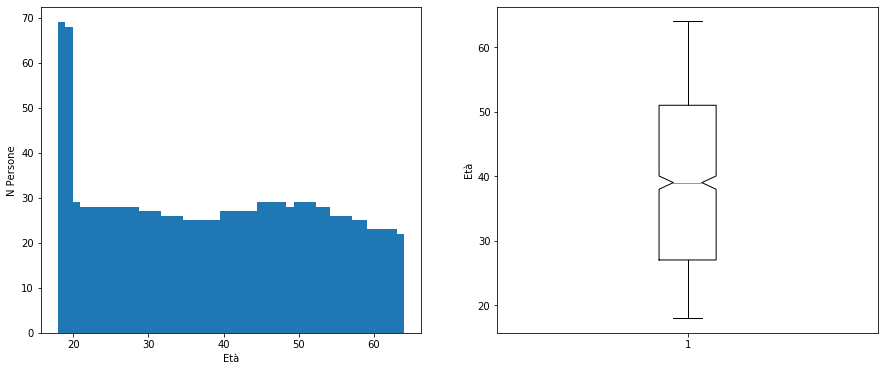

In [17]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.hist(insurance_data.age, bins=47)
plt.ylabel('N Persone')
plt.xlabel('Età')

plt.subplot(1,2,2)
plt.ylabel('Età')
plt.boxplot(insurance_data.age, notch=True)
insurance_data.loc[insurance.age < 20].age.value_counts()

- Come si può notare dal grafico, si ha una distribuzione dell'età equa delle sottoscrizioni dell'assicurazione medica
- Fatta eccezione per i contraenti con 18 e 19 anni

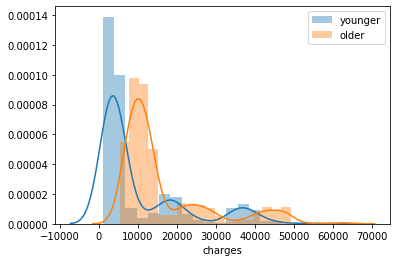

In [18]:
middle_age = np.round(insurance.age.mean()) # 39.207025 --> 39
sns.distplot(insurance.loc[insurance.age <= middle_age ]['charges'])
sns.distplot(insurance.loc[insurance.age > middle_age]['charges'])
plt.legend(['younger', 'older']);

- Una maggiore età sicuramente influenza il minimo della nostra variabile obiettivo, ma non la influenza globalmente.
- Ci aspettiamo un coefficiente di correlazione superiore allo 0 ma non molto alto

In [19]:
correlation(insurance.age, insurance.charges)

0.29878471934460105

##### Analisi della colonna `bmi`
- L'indice di massa corporea è rappresentativo della fisicità ($\frac{Altezza}{peso^2}$) di una persona

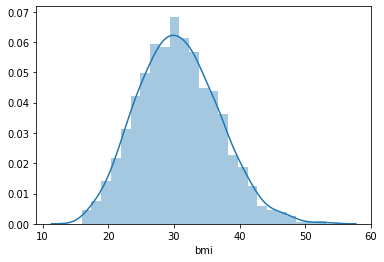

In [20]:
sns.distplot(insurance.bmi);

- La maggioranza delle persone prese in esame ha un BMI superiore a `24.9`, indice massimo del normopeso
- La media è 30, indice di obesità

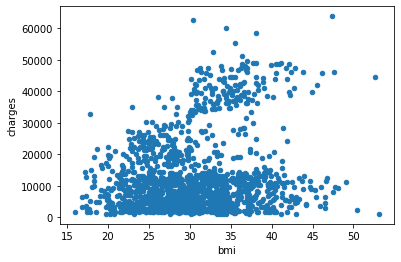

In [21]:
insurance_data.plot.scatter('bmi', 'charges');

- Si può già notare come un BMI superiore al normopeso possa essere indice di un aumento del costo dell'assicurazione
- Andiamo a studiare nel dettaglio il costo per chi è entro il normopeso e per chi non lo è

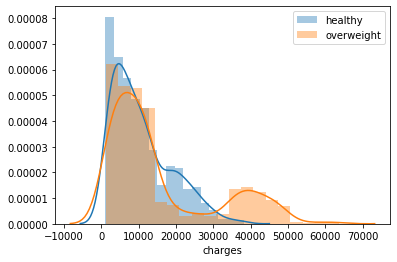

In [22]:
healthy = insurance.loc[insurance.bmi < 30]
overweight = insurance.loc[insurance.bmi >= 30]

sns.distplot(healthy['charges'])
sns.distplot(overweight['charges'])
plt.legend(['healthy', 'overweight']);

- I pazienti con un BMI superiore a 30 hanno un costo maggiore, come da aspettativa

In [23]:
correlation(insurance.bmi, insurance.charges)

0.19819273193614506

### Variabili discrete

##### Analisi della colonna `children`

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

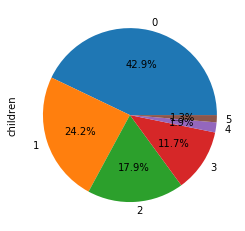

In [24]:
insurance['children'].value_counts().plot.pie(autopct='%1.1f%%');
insurance['children'].value_counts()

- La maggiorparte dei soggetti non ha figli (42.9%)
- Una minima parte dei soggetti ha fra i 3 e i 5 figli (<15%)

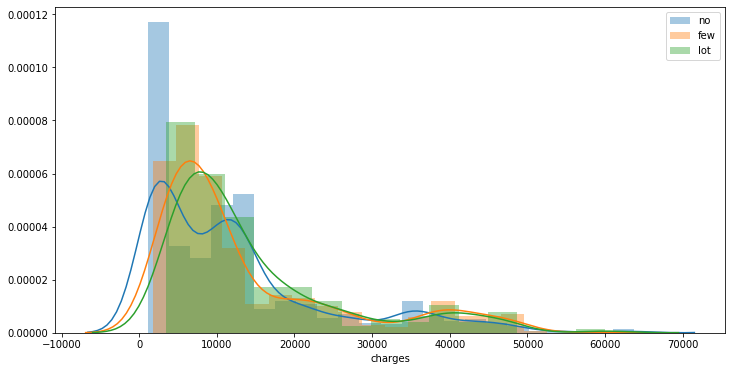

In [25]:
plt.figure(figsize=(12, 6))
no_children = insurance.loc[insurance.children == 0]
few_children = insurance.loc[(insurance.children > 0) & (insurance.children < 3)]
lot_children = insurance.loc[insurance.children >= 3]
sns.distplot(no_children['charges'])
sns.distplot(few_children['charges'])
sns.distplot(lot_children['charges'])
plt.legend(['no', 'few', 'lot']);

- Il numero di figli non sembra far aumentare i costi direttamente, piuttosto un aumento molto leggero del minimo valore della nostra variabile obiettivo
- Di conseguenza, ci aspettiamo un coefficiente di correlazione prossimo allo 0 e minore rispetto a quello calcolato sull'età

In [26]:
correlation(insurance.children, insurance.charges)

0.0679474060505599

## Preparazione dei dati

- Estraiamo dal nostro dataset
    - La Series `y` contenente i valori della colonna `charges` da predire
    - Il DataFrame `X` con i valori di tutte le altre colonne, utili per la predizione

In [27]:
y = insurance_data['charges']
X = insurance_data.drop(columns='charges')

In [28]:
y.head(5)

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [29]:
X.head(3).append(X.tail(3))

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.90,0,1,0,0,0,1
1,18,1,33.77,1,0,0,0,1,0
2,28,1,33.00,3,0,0,0,1,0
1335,18,0,36.85,0,0,0,0,1,0
1336,21,0,25.80,0,0,0,0,0,1
1337,61,0,29.07,0,1,0,1,0,0


- Dividiamo il dataset in training e validation set attraverso il metodo _hold out_

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

## Modelli

- Partiamo alla ricerca del modello migliore partendo da un semplice modello lineare, proseguendo poi con i vari modelli

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7650433625569815

In [32]:
lrm = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
lrm.fit(X_train, y_train)
lrm.score(X_val, y_val)

0.7650717650337552

In [33]:
plrm = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])
plrm.fit(X_train, y_train)
plrm.score(X_val, y_val)

0.8544448416983839

In [34]:
model = KernelRidge(alpha=1, kernel='poly', degree=2)
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8537902012283942

- La scelta di utilizzare una regressione non lineare è quella con i risultati migliori
- Ora testiamo, utilizzando la Grid Search e la K Fold Validation, il modello per cercare i paremetri migliori (se esistono)

In [35]:
### KFOLD 
kf = KFold(5, shuffle=True, random_state=42)
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regr', KernelRidge(kernel='poly'))
])
grid = {
    'regr__degree': range(1, 5),
    'regr__alpha': [0.01, 0.1, 1, 10]
}
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
print(gs.best_params_)
gs.score(X_val, y_val)

{'regr__alpha': 1, 'regr__degree': 2}


0.8544791436845189

- La grid search ci dà la conferma che il risultato migliore si ottiene con un alpha pari a 1 e grado polinomiale pari a 2

In [36]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__alpha,param_regr__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.015558,0.001017,0.001995,2.431402e-07,1,2,"{'regr__alpha': 1, 'regr__degree': 2}",0.884446,0.788276,0.842273,0.866187,0.772676,0.830784,0.043482,1
5,0.015359,0.000798,0.001795,3.990653e-04,0.1,2,"{'regr__alpha': 0.1, 'regr__degree': 2}",0.884956,0.786829,0.843127,0.866233,0.772126,0.830666,0.044095,2
1,0.015160,0.001595,0.001795,3.990415e-04,0.01,2,"{'regr__alpha': 0.01, 'regr__degree': 2}",0.884970,0.786624,0.843177,0.866197,0.772025,0.830611,0.044163,3
14,0.030420,0.000891,0.006383,7.977247e-04,10,3,"{'regr__alpha': 10, 'regr__degree': 3}",0.880217,0.783428,0.836512,0.860185,0.770915,0.826264,0.042594,4
15,0.032617,0.001535,0.005784,9.771163e-04,10,4,"{'regr__alpha': 10, 'regr__degree': 4}",0.880606,0.773912,0.841587,0.858034,0.770029,0.824839,0.044943,5
10,0.032114,0.001596,0.006085,7.971618e-04,1,3,"{'regr__alpha': 1, 'regr__degree': 3}",0.878054,0.768949,0.843547,0.851873,0.764761,0.821441,0.046038,6
13,0.014162,0.000977,0.001995,2.336015e-07,10,2,"{'regr__alpha': 10, 'regr__degree': 2}",0.867637,0.779725,0.823558,0.851177,0.762791,0.816993,0.040267,7
6,0.033314,0.000733,0.006183,9.769510e-04,0.1,3,"{'regr__alpha': 0.1, 'regr__degree': 3}",0.869220,0.756458,0.837826,0.841302,0.759351,0.812832,0.046184,8
2,0.033212,0.002516,0.006183,7.460853e-04,0.01,3,"{'regr__alpha': 0.01, 'regr__degree': 3}",0.867388,0.753680,0.836205,0.839323,0.758365,0.810991,0.046228,9
11,0.032513,0.002054,0.006085,9.145652e-04,1,4,"{'regr__alpha': 1, 'regr__degree': 4}",0.848473,0.744987,0.838033,0.840308,0.755980,0.805536,0.045252,10


In [37]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8544448416983839

In [38]:
pd.Series(model.coef_, index=X_train.columns)

AttributeError: 'Pipeline' object has no attribute 'coef_'

In [ ]:
pd.Series(model.coef_, index=X_train.columns)